# Pharaglow Analysis Notebook

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import shutil
import timeit
from datetime import date
# image io and analysis
import json
import pims
from skimage.io import imsave
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
import pharaglow
from pharaglow import tracking, run, features, util, io, extract

# show logger messabes loally
import logging
logging.debug('pharaglow')
# reduce the output messages from trackpy
tp.quiet(suppress=True)

This notebook runs the pharaglow image analysis pipeline. It comprises three stages on analysis which can be done sequentially and are independent. Analyses can be interrupted at the end of each stage after saving the output dataframe. 

**1. Step -  Basic object detection**
    This step creates a "_features.json" file which contains a table of objects detected in each frame.
    Beyond finding the center of mass of an object, no further image analysis is done here.
    
**2. Step - Linking objects into trajectories**
    This results in individual files "_trajectory.json" for each tracked animal.
    
**3. Step - Analysing the details of object shapes**
    This step is doing the heavy lifting: It extracts centerlines, widths, contours and other object descriptors from the objects

All subsequent analyses steps add 'columns' to the data, and thus features is a subset of trajectories is a subset of results.

## 1. Setup

In [2]:
def setup(parameterfile, inPath, outPath, movie):
    """helper function to simplify the setting up before analysis. Handles path checking and creating, parameter reads ad data reads."""
    npaths = {'parameter file': parameterfile,
          'inPath':inPath,
          'outPath': outPath}
    ### start a logger
    today = date.today().strftime("%Y%m%d")
    logger = io.log_setup('PharaGlow', 10, fname = os.path.join(outPath, f'{today}_{movie}_pharaglow_log.txt'))
    ### create filenames
    fname = os.path.join(inPath,"*.tif*")
    outfile = os.path.join(outPath, movie+"_{}_{}.json")
    imfile =  os.path.join(outPath, movie+"_{}_{}.tiff")
    saveparam = os.path.join(outPath, movie+"_parameters")
    
    logger.info(f"parameters file will be saved as {saveparam}")
    logger.info(f"output file will be saved as {outfile}")
    logger.info(f"image files will be saved as {imfile}")
    # check if all the paths exist
    for key, value in npaths.items():    
        if os.path.exists(value):
            logger.info(f'{key}: {value}')
        else:
            logger.warning(f"Warning! The path for {key} doesnt exist: {value}")
    logger.info(f"Loading parameters from {parameterfile}...")
    ### load analysis parameters
    with open(parameterfile) as f:
        param = json.load(f)
    logger.info(f"parameters file loaded as 'param':{param}")
    # save a copy of the parameters
    logger.info("Saving parameters...")
    with open(saveparam, 'w') as f:
        json.dump(param, f)
    logger.info(f"parameters saved as {parameterfile}")
    
    ### load lawns
    if lawnPath is not None and lawnPath != 'None':
        try:
            lawnfile = os.path.join(lawnPath,movie+'_lawn.tiff')
            lawn = pims.open(lawnfile)[0]
            binLawn = features.findLawn(lawn)
        except Exception:
            lawnfile = os.path.join(lawnPath,movie+'_lawn.bmp')
            lawn = pims.open(lawnfile)[0]
            binLawn = features.findLawn(lawn)
        logger.info("Lawnfile opened as 'lawn'")
    else:
        lawn = None
        
    ### load images
    start = timeit.default_timer()
    logger.info("Loading tiff files.")
    rawframes = pims.open(fname)
    stop = timeit.default_timer()
    logger.info(f"image loading time: {stop - start}s")  
    nfiles = len([f for f in os.listdir(inPath) if '.tif' in f])
    # tiff files
    logger.info(f"Number of tiff files: {nfiles}")
    # rawframes 
    logger.info(f"Number of rawframes: {len(rawframes)}")

    if nfiles != len(rawframes):
        logger.warning("the number of tiff files doesn't match with the number of rawframes !")

    return logger, param, rawframes, lawn, outfile, imfile
    
    

### Input parameters

In [10]:
parameterfile = r"C:\Users\bonnard\Documents\GitHub\PharaGlow\AnalysisParameters_1x.json"
inPath = r"C:\Users\bonnard\Documents\DATA\demo_data\MS0006"
outPath = r"C:\Users\bonnard\Documents\DATA\demo_data\pg_out"
movie = "MS0006"

nWorkers = 4

depth = 'uint8'
save_minimal = True

lawnPath = None #"/opt/data/Lawns/"

In [11]:
logger, param, rawframes, lawn, outfile, imfile = setup(parameterfile, inPath, outPath, movie)

INFO:PharaGlow:parameters file will be saved as C:\Users\bonnard\Documents\DATA\demo_data\pg_out\MS0006_parameters
INFO:PharaGlow:output file will be saved as C:\Users\bonnard\Documents\DATA\demo_data\pg_out\MS0006_{}_{}.json
INFO:PharaGlow:image files will be saved as C:\Users\bonnard\Documents\DATA\demo_data\pg_out\MS0006_{}_{}.tiff
INFO:PharaGlow:parameter file: C:\Users\bonnard\Documents\GitHub\PharaGlow\AnalysisParameters_1x.json
INFO:PharaGlow:inPath: C:\Users\bonnard\Documents\DATA\demo_data\MS0006
INFO:PharaGlow:outPath: C:\Users\bonnard\Documents\DATA\demo_data\pg_out
INFO:PharaGlow:Loading parameters from C:\Users\bonnard\Documents\GitHub\PharaGlow\AnalysisParameters_1x.json...
INFO:PharaGlow:parameters file loaded as 'param':{'subtract': 1, 'smooth': 1, 'dilate': 2, 'tfactor': 1, 'thresholdWindow': 30, 'bgWindow': 30, 'length': 100, 'watershed': 100, 'minSize': 600, 'maxSize': 1500, 'searchRange': 10, 'memory': 30, 'minimalDuration': 600, 'widthStraight': 10, 'pad': 5, 'nPts

## 2. Object detection

### Create binary masks

In [12]:
start = timeit.default_timer()

# detecting objects
logger.info('Binarizing images...')

masks = tracking.calculateMask(rawframes,
                               bgWindow = param['bgWindow'],
                               thresholdWindow = param['thresholdWindow'],
                               smooth =  param['smooth'],
                               subtract =  param['subtract'],
                               dilate = param['dilate'],
                               tfactor=param['tfactor'])


stop = timeit.default_timer()
logger.info(f"binary masks created ({stop - start}s)")  

INFO:PharaGlow:Binarizing images...
INFO:PharaGlow:binary masks created (6.896687699999973s)


### Make sure the thresholding worked otherwise change parameters

In [14]:
# Select a rawframe to visualize
t = 400 

if t> (len(rawframes)-1):
    # Check if the selected rawframe is present otherwise t=0
    print(f"Warning ! Max {len(rawframes)} rawframes. {t} changed to 0")
    t=0

print(f"rawframe {t} to visualize ")

rawframe 400 to visualize 


##### Visualize the raw data

figure saved as C:\Users\bonnard\Documents\DATA\demo_data\pg_out\2023-02-16_MS0006_frame400_hist.pdf


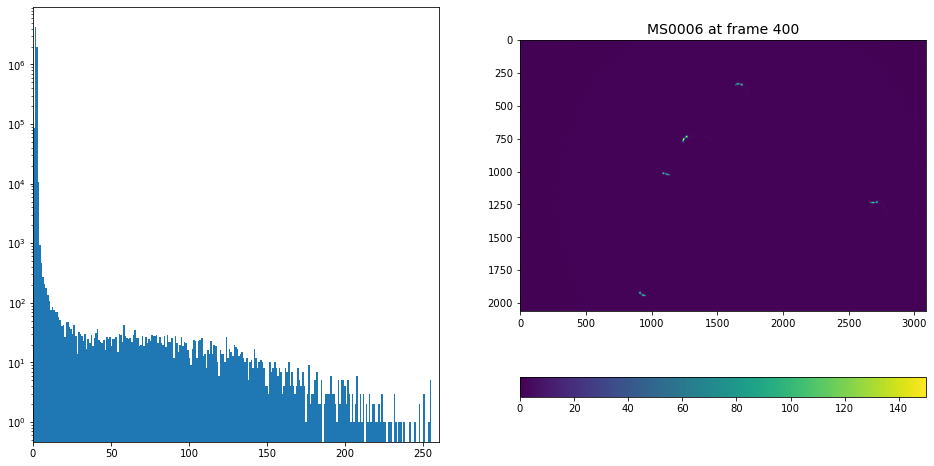

In [23]:
plt.figure(figsize=(16,8))

plt.subplot(121)
# Plot the histogram of the pixel intensity values of the rawframe
plt.hist(rawframes[t].ravel(), bins=256, log=True)
plt.xlim(0, 260) # xlim for 8 bits image

plt.subplot(122)
# Adjust the color limit for the rawframe for vizualisation only
color = (0,150) #  0<=color<=255 for 8 bits image
# color = None 
plt.imshow(rawframes[t],clim = color)
plt.colorbar(orientation='horizontal');
plt.title(f"{movie} at frame {t}", fontsize=14)  

# Save
fig_path = os.path.join(outPath,f'{date.today()}_{movie}_frame{t}_hist.pdf')
plt.savefig(fig_path)
print("figure saved as", fig_path)

##### Show the mask and detected objects

5 detected objects
figure saved as  C:\Users\bonnard\Documents\DATA\demo_data\pg_out\2023-02-16_MS0006_frame400_masks.pdf


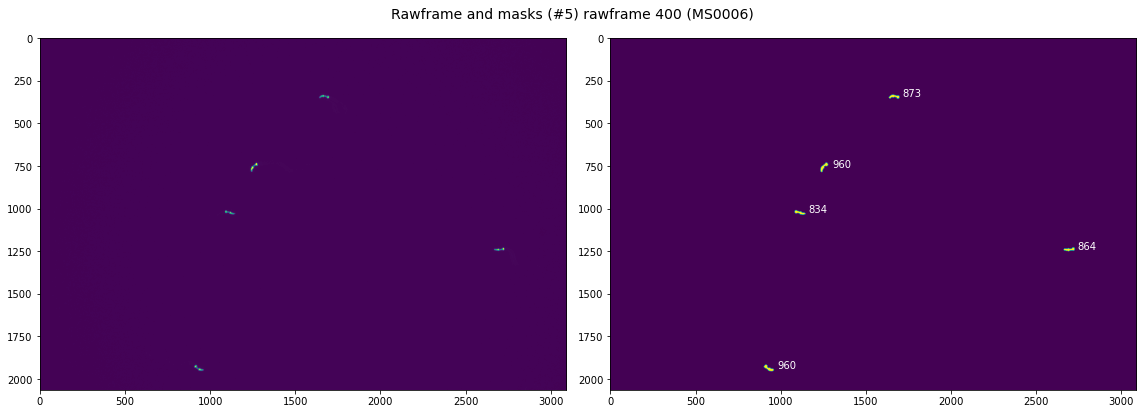

In [18]:
# %matplotlib qt

from skimage.measure import label, regionprops

plt.figure(figsize=(16,6))
plt.subplot(121)
# Show the rawframe
plt.imshow(rawframes[t],clim= color)#+lawn)
if lawn is not None:
    # Show the lawn
    plt.contour(binLawn, alpha=0.5, cmap='pink')
    
plt.subplot(122)
# Show the masks and their size [px]
plt.imshow(masks[t])#[:600,1000:])#[500:1500,2000:3500])#[:,2500:])
# print(np.min(masks[t]))
label_image, num = label(masks[t], background=0, connectivity = 1,return_num=True)
print(f"{num} detected objects")
for region in regionprops(label_image):
    plt.text(region.centroid[1]+50, region.centroid[0], region.area, color ='w')

plt.suptitle(f"Rawframe and masks (#{num}) rawframe {t} ({movie})", fontsize=14)    
plt.tight_layout()

# save the pdf
fig_path = os.path.join(outPath,f'{date.today()}_{movie}_frame{t}_masks.pdf')
plt.savefig(fig_path)
print("figure saved as", fig_path)

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

This section will go through all frames and find worm-sized (as specified by the parameters) objects. It creates a pd.Dataframe containing these and a stack of images (numpy array) that contain a cropped area around each worm. Note: Each worm image will be length x length x 8bit. So with 30 worms per image you expect the image array to be 6Gb/10 minutes.

In [ ]:
start = timeit.default_timer()

logger.info('Detecting features...')
logger.info(f'...with {nWorkers} workers')
objects, images = util.parallel_analysis((masks, rawframes), param, tracking.parallelWorker, framenumbers = None, nWorkers = nWorkers, output= None, depth = depth)
# create a link between image and dataframe
objects['im_idx'] = np.arange(len(objects))
stop = timeit.default_timer()
logger.info(f"features detected ({stop - start}s)") 

INFO:PharaGlow:Detecting features...
INFO:PharaGlow:...with 4 workers


In [ ]:
# Files monitoring
logger.info(f" Number of frames in features:{objects['frame'].nunique()}")
                                                       
if len(rawframes) != len(objects['frame'].unique()):
    logger.warning(f" Number of frames in features ({objects['frame'].nunique()}) and the number of rawframes ({len(rawframes)}) don't match !")

#### Visualize results of object detection

In [ ]:
### Show the area of all objects
plt.figure(figsize=(12,6))
plt.subplot(121)
objects['area'].hist(bins = 30)
plt.xlabel('Area (px)')
plt.subplot(122)
objects['frame'].value_counts().sort_index().plot()
plt.ylabel('Number of objects')
plt.xlabel('Frame')

# save the pdf
plt.title(f"{movie}", fontsize=24)
plt.savefig(os.path.join(outPath,f'{date.today()}_{movie}_objects_.pdf'))

logger.info(f"features.area.min():{objects.area.min()}") # region.area > params['minSize']
logger.info(f"features.area.max():{objects.area.max()}") # region.area < params['maxSize']

### Save features and images

In [12]:
start = timeit.default_timer()
# saving features
logger.info("Saving features...")
objects.info(memory_usage='deep')
objects.to_json(outfile.format('features', 'all'), orient='split')
stop = timeit.default_timer()
logger.info(f"features saved as {outfile.format('features', 'all')} ({stop - start}s)")

start = timeit.default_timer()
# saving images
imsave(imfile.format('images', 'all'), images)
stop = timeit.default_timer()
logger.info(f"images saved as {imfile.format('images', 'all')} ({stop - start}s)")



INFO:PharaGlow:Saving features...
INFO:PharaGlow:features saved as C:\Users\bonnard\Documents\DATA\3_1_pharaglow\demo_data\demo_data_features_all.json (0.020175300000005336s)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         5077 non-null   float64
 1   x         5077 non-null   float64
 2   slice_y0  5077 non-null   int64  
 3   slice_y1  5077 non-null   int64  
 4   slice_x0  5077 non-null   int64  
 5   slice_x1  5077 non-null   int64  
 6   frame     5077 non-null   int64  
 7   area      5077 non-null   int64  
 8   yw        5077 non-null   float64
 9   xw        5077 non-null   float64
 10  shapeY    5077 non-null   int32  
 11  shapeX    5077 non-null   int32  
 12  im_idx    5077 non-null   int32  
dtypes: float64(4), int32(3), int64(6)
memory usage: 456.3 KB


INFO:PharaGlow:images saved as C:\Users\bonnard\Documents\DATA\3_1_pharaglow\demo_data\demo_data_images_all.tiff (0.320130899999981s)


#### (Optional) Load features and images if continuing prior analysis

In [13]:
%%time
# leaving this here for re-analysis
if False:
    # Load feature
    start = timeit.default_timer()
    logger.info("Loading features...")
    objects = io.load(outfile.format('features', 'all'), orient='split')
    images = pims.open(imfile.format('images', 'all'))
    stop = timeit.default_timer()
    logger.info(f"features loaded ({stop - start}s)")

Wall time: 0 ns


## 3. Creating trajectories

### Link objects to trajectories using trackpy and interpolate short misses

In [14]:
logger.info('Linking trajectories...')
logger.info(f"Parameter searchRange: {param['searchRange']} px")
logger.info(f"Parameter memory: {param['memory']} frames")

INFO:PharaGlow:Linking trajectories...
INFO:PharaGlow:Parameter searchRange: 10 px
INFO:PharaGlow:Parameter memory: 30 frames


In [15]:
#pred = tp.predict.NearestVelocityPredict()
#trajectories = pred.link_df(features,param['searchRange'], memory = param['memory'])
trajectories = tp.link_df(objects,param['searchRange'], memory = param['memory'])
logger.info(f"Number of trajectories after linking: {len(trajectories['particle'].unique())}")

INFO:PharaGlow:Number of trajectories after linking: 8


In [16]:
# Delete the variable features to save memory
del objects

#### Show the trajectories

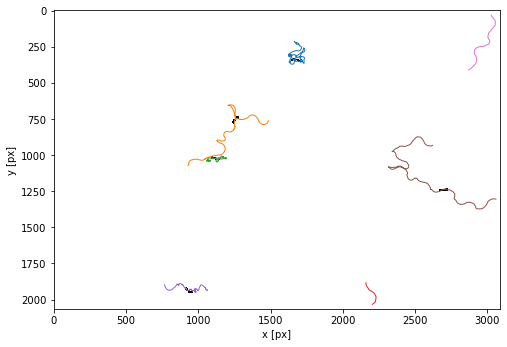

In [17]:
plt.figure(figsize=(8,8))
tp.plot_traj(trajectories, colorby = 'particle', superimpose=1-masks[t],label=False);

In [18]:
logger.info(f"Filtering out trajectories which last less than the minimal duration ({param['minimalDuration']} frames)...")
logger.info(f"Nb of trajectories before filtering: {trajectories['particle'].nunique()}")

trajectories = tp.filter_stubs(trajectories,param['minimalDuration'])
logger.info(f"Nb of trajectories after filtering: {trajectories['particle'].nunique()}")

INFO:PharaGlow:Filtering out trajectories which last less than the minimal duration (600 frames)...
INFO:PharaGlow:Nb of trajectories before filtering: 8
INFO:PharaGlow:Nb of trajectories after filtering: 5


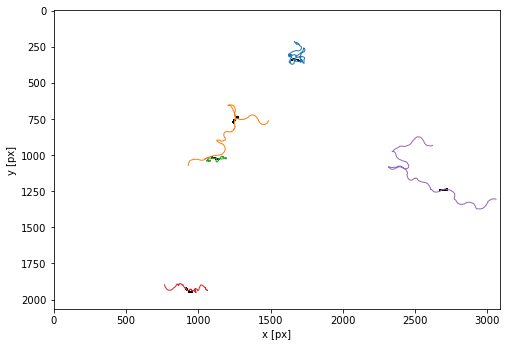

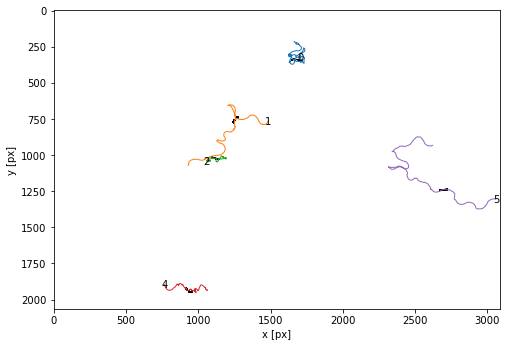

In [19]:
fig = plt.figure(figsize=(8,8))
ax = tp.plot_traj(trajectories, colorby = 'particle', superimpose=1-masks[t],label=False);
# save the pdf
ax.set_title(f"{movie}", fontsize=24)
fig.savefig(os.path.join(outPath,f'{date.today()}_{movie}_trajectories_filtered.pdf'))

# with labels
fig = plt.figure(figsize=(8,8))
ax = tp.plot_traj(trajectories, colorby = 'particle', superimpose=1-masks[t],label=True);
# save the pdf
ax.set_title(f"{movie}", fontsize=24)
fig.savefig(os.path.join(outPath,f'{date.today()}_{movie}_trajectories_filtered_labelled.pdf'))

#### Save individual trajectories & add the missing images to interpolated trajectories

Here we do multiple things: Add missing rows to the trajectory, create a separate image stack for each animal and save the trajectories.

#### Extract lawn info

In [20]:
def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawn is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

In [21]:
logger.info(f"Saving {trajectories['particle'].nunique()} trajectories to separate files...")

start = timeit.default_timer()

for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index].copy()
    ims = images[tmp['im_idx']]
    ims = np.array(ims, dtype = 'uint8')
    # generate an interpolated trajectory where all frames are accounted for
    traj_interp, ims_interp = tracking.interpolate_helper(rawframes, ims, tmp, param)
    # save the new single worm movie
    imsave(imfile.format('images', particle_index), np.array(ims_interp, dtype='uint8'))
    # add some basic image properties
    traj_interp = features.calculateImageproperties(traj_interp, ims_interp)
    # save the trajectory
    traj_interp.to_json(outfile.format('trajectories', int(particle_index)), orient='split')
    
stop = timeit.default_timer()
logger.info(f"trajectories saved as json files ({stop - start}s)") 



INFO:PharaGlow:Saving 5 trajectories to separate files...
INFO:PharaGlow:trajectories saved as json files (0.7889825999999402s)


## 3. Run the whole pharaglow feature extraction

In [22]:
start = timeit.default_timer()
# save only minimal outputs - reduces save by approx factor 3

# analyze all trajectories
for fn in os.listdir(outPath):
    file = os.path.join(outPath,fn)
    
    if os.path.isfile(file) and f'{movie}_trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        traj =  io.load(file, orient='split')
        # load images
        images = pims.open(imfile.format('images', particle_index))
        if len(traj.index)<1:
            print('Skipped', file)
            continue
        logger.info('Analyzing trajectory:%s', fn)
        
        tmp,_ = util.parallel_analysis((images,), param,\
                          parallelWorker= run.parallel_pharaglow_run, framenumbers = traj['frame'], nWorkers = nWorkers, output= None)
        # remove some columns to make the result smaller
        if save_minimal:
            tmp = tmp.drop(['Mask', 'SkeletonX', 'SkeletonY', 'ParX', 'ParY', 
                            'Xstart', 'Xend', 'dCl', 'Widths', 'Contour', 'Gradient', 
                            'Kymo', 'KymoGrad', 'Similarity', 'Xtmp'], axis = 1, errors = 'ignore')
        # add the basic tracker info - you can also keep these as separate files
        tmp = tmp.merge(traj, on='frame', how = 'outer')
        # drop nans to allow post processing
        tmp = tmp.dropna(how='all')
        tmp = tmp[tmp['Straightened'].notna()]
        print(tmp.info())
        # run some stuff on the whole dataframe.
        run.pharynxorientation(tmp)
        # extract pumps
        tmp[['pumps']] = tmp.apply(\
        lambda row: pd.Series(features.extractPump(row['Straightened'])), axis=1)
        # get more exact entry location
        if lawn is not None:
            tmp['insideHead'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], binLawn)), axis=1)
            tmp['insideHeadIntensity'] = tmp.apply(\
                lambda row: pd.Series(features.headLocationLawn(row['Centerline'],row['slice'], lawn)), axis=1)
        
        tmp.to_json(outfile.format('results', particle_index), orient='split')
        
if save_minimal:
    logger.info('minimal information saved')
    
stop = timeit.default_timer()
logger.info(f"Whole pharaglow features extracted ({stop - start}s)")  

INFO:PharaGlow:Analyzing trajectory:demo_data_trajectories_0.json


Analyzing image 0 of 999
Analyzing image 100 of 999
Analyzing image 200 of 999
Analyzing image 300 of 999
Analyzing image 400 of 999
Analyzing image 500 of 999
Analyzing image 600 of 999
Analyzing image 700 of 999
Analyzing image 800 of 999
Analyzing image 900 of 999
<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Centerline    999 non-null    object 
 1   Straightened  999 non-null    object 
 2   frame         999 non-null    int64  
 3   Imax          999 non-null    uint8  
 4   Imean         999 non-null    float64
 5   Imedian       999 non-null    float64
 6   Istd          999 non-null    float64
 7   Area2         999 non-null    int64  
 8   image_index   999 non-null    int64  
 9   has_image     999 non-null    int64  
 10  y             999 non-null    float64
 11  x             999 non-null    float64
 12  slice_y0      999 no

C:\ProgramData\Anaconda3\envs\pumping\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\pumping\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:PharaGlow:Analyzing trajectory:demo_data_trajectories_1.json


Analyzing image 0 of 999
Analyzing image 100 of 999
Analyzing image 200 of 999
Analyzing image 300 of 999
Analyzing image 400 of 999
Analyzing image 500 of 999
Analyzing image 600 of 999
Analyzing image 700 of 999
Analyzing image 800 of 999
Analyzing image 900 of 999
<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Centerline    999 non-null    object 
 1   Straightened  999 non-null    object 
 2   frame         999 non-null    int64  
 3   Imax          999 non-null    uint8  
 4   Imean         999 non-null    float64
 5   Imedian       999 non-null    float64
 6   Istd          999 non-null    float64
 7   Area2         999 non-null    int64  
 8   image_index   999 non-null    int64  
 9   has_image     999 non-null    int64  
 10  y             999 non-null    float64
 11  x             999 non-null    float64
 12  slice_y0      999 no

INFO:PharaGlow:Analyzing trajectory:demo_data_trajectories_2.json


Analyzing image 0 of 791
Analyzing image 100 of 791
Analyzing image 200 of 791
Analyzing image 300 of 791
Analyzing image 400 of 791
Analyzing image 500 of 791
Analyzing image 600 of 791
Analyzing image 700 of 791
<class 'pandas.core.frame.DataFrame'>
Int64Index: 791 entries, 0 to 790
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Centerline    791 non-null    object 
 1   Straightened  791 non-null    object 
 2   frame         791 non-null    int64  
 3   Imax          791 non-null    uint8  
 4   Imean         791 non-null    float64
 5   Imedian       791 non-null    float64
 6   Istd          791 non-null    float64
 7   Area2         791 non-null    int64  
 8   image_index   791 non-null    int64  
 9   has_image     791 non-null    int64  
 10  y             791 non-null    float64
 11  x             791 non-null    float64
 12  slice_y0      791 non-null    int64  
 13  slice_y1      791 non-null    i

INFO:PharaGlow:Analyzing trajectory:demo_data_trajectories_4.json


Analyzing image 0 of 999
Analyzing image 100 of 999
Analyzing image 200 of 999
Analyzing image 300 of 999
Analyzing image 400 of 999
Analyzing image 500 of 999
Analyzing image 600 of 999
Analyzing image 700 of 999
Analyzing image 800 of 999
Analyzing image 900 of 999
<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Centerline    999 non-null    object 
 1   Straightened  999 non-null    object 
 2   frame         999 non-null    int64  
 3   Imax          999 non-null    uint8  
 4   Imean         999 non-null    float64
 5   Imedian       999 non-null    float64
 6   Istd          999 non-null    float64
 7   Area2         999 non-null    int64  
 8   image_index   999 non-null    int64  
 9   has_image     999 non-null    int64  
 10  y             999 non-null    float64
 11  x             999 non-null    float64
 12  slice_y0      999 no

INFO:PharaGlow:Analyzing trajectory:demo_data_trajectories_5.json


Analyzing image 0 of 796
Analyzing image 100 of 796
Analyzing image 200 of 796
Analyzing image 300 of 796
Analyzing image 400 of 796
Analyzing image 500 of 796
Analyzing image 600 of 796
Analyzing image 700 of 796
<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 0 to 795
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Centerline    796 non-null    object 
 1   Straightened  796 non-null    object 
 2   frame         796 non-null    int64  
 3   Imax          796 non-null    uint8  
 4   Imean         796 non-null    float64
 5   Imedian       796 non-null    float64
 6   Istd          796 non-null    float64
 7   Area2         796 non-null    int64  
 8   image_index   796 non-null    int64  
 9   has_image     796 non-null    int64  
 10  y             796 non-null    float64
 11  x             796 non-null    float64
 12  slice_y0      796 non-null    int64  
 13  slice_y1      796 non-null    i

INFO:PharaGlow:minimal information saved
INFO:PharaGlow:Whole pharaglow features extracted (1059.359258s)


#### Check if data has been analyzed

In [23]:
# Files monitoring
files_list = os.listdir(outPath)
f1 =[]
f2 =[]

path = os.path.dirname(outfile)

for fn in files_list:
    file = os.path.join(path,fn)
    if os.path.isfile(file) and f'{movie}_trajectories_' in fn  and fn.endswith('.json'):
        if not 'all' in fn: 
            particle_index = int(fn.split('.')[0].split('_')[-1])
            f1.append(particle_index)
    if os.path.isfile(file) and f'{movie}_results_' in fn and fn.endswith('.json'): 
        particle_index = int(fn.split('.')[0].split('_')[-1])
        f2.append(particle_index)

logger.info('trajectories.json files: %s ', len(f1))
logger.info('results.json files: %s ', len(f2))
if len(f1) != len(f2):
    logger.warning('trajectories - results: %s', set(f1).symmetric_difference(set(f2)))

INFO:PharaGlow:trajectories.json files: 5 
INFO:PharaGlow:results.json files: 5 


In [24]:
logger.info("PharaGlow ends here")

INFO:PharaGlow:PharaGlow ends here
